In [687]:
# Do we need to train the discriminator and generator?
# or just load the weights?
TRAIN_DISCRIMINATOR = False
TRAIN_GENERATOR = False
WGAN = False
TARGET_DIGIT = 8
MUTATE_POOL = True
LOSS_TYPE = 'l2

iters_lower, iters_upper = 120, 121


In [688]:
#@title imports and notebook utils

import time
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import imageio
import random



import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential, backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
from keras.initializers import RandomNormal

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

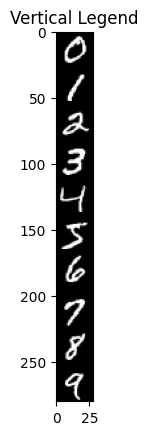

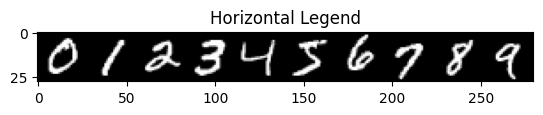

In [689]:
# @title Generate train/test set from MNIST.

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = 1 * ((train_images) / 255)
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Separate images of '1' and other digits
images_of_target = train_images[train_labels == TARGET_DIGIT]
images_of_others = train_images[train_labels != TARGET_DIGIT]

# Downsample the 'other digits' dataset to match the size of '1s' dataset
size_of_targets = images_of_target.shape[0]
downsampled_images_of_others = images_of_others[:size_of_targets]

# Combine and shuffle the datasets
combined_images = np.concatenate((images_of_target, downsampled_images_of_others), axis=0)
combined_labels = np.concatenate((np.ones(size_of_targets), np.zeros(size_of_targets)), axis=0)

# # Shuffle the combined dataset
# shuffled_indices = np.random.permutation(combined_images.shape[0])
# combined_images = combined_images[shuffled_indices]
# combined_labels = combined_labels[shuffled_indices]

# Create the TensorFlow dataset
x_train = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# take a target image
target_image = images_of_target[5]



def to_ten_dim_label(x, y):
    # x shape is [b, r, c]
    # y shape is [b]
    y_res = np.zeros(list(x.shape) + [10])
    y_expanded = np.broadcast_to(y, x.T.shape).T
    y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
    return y_res.astype(np.float32)

y_train_pic = to_ten_dim_label(train_images, train_labels)

def find_bw_legend(x_set, y_set, orientation="vertical"):
    result_x = []
    for i in range(10):
        for x, y in zip(x_set, y_set):
            if y == i:
                result_x.append(x)
                break
    assert len(result_x) == 10

    if orientation == "vertical":
        result_x = np.concatenate(result_x, axis=0)
    else:
        result_x = np.concatenate(result_x, axis=1)

    return result_x

# Create vertical and horizontal black and white legends
bw_legend_vertical = find_bw_legend(train_images, train_labels, orientation="vertical")
bw_legend_horizontal = find_bw_legend(train_images, train_labels, orientation="horizontal")

# Show the legend using matplotlib or some other library of your choice
import matplotlib.pyplot as plt

plt.imshow(bw_legend_vertical, cmap='gray')
plt.title('Vertical Legend')
plt.show()

plt.imshow(bw_legend_horizontal, cmap='gray')
plt.title('Horizontal Legend')
plt.show()


In [690]:
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5

In [691]:
#@title CA model and utils
def to_greyscale(x):
    return tf.clip_by_value(x[..., 0:1], 0.0, 1.0)

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(num_examples, height = 9, width = 4):
    h, w = 28,28
    seed = np.zeros([num_examples, h, w, CHANNEL_N], np.float32)
    for i in range(h//2 - height, h//2 + height):
        for j in range(w//2-width, w//2 + width):
            seed[:, i, j, 0] = np.random.uniform(1, 1, size = num_examples)
    return seed

class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

# class build_generator(tf.keras.Model):

#     def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, l2_reg = 0):
#         super().__init__()
#         self.channel_n = channel_n
#         self.fire_rate = fire_rate
#         self.custom_init = CustomInitializer(mean=0) #was 0.008

#         self.dmodel = tf.keras.Sequential([
#             Conv2D(128, 1, activation=tf.nn.relu, kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
#             Conv2D(self.channel_n, 1, activation=None,
#                 kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
#         ])

#         self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

#     def reinitialize_weights(self):
#         for layer in self.dmodel.layers:
#             if hasattr(layer, 'kernel_initializer'):
#                 layer.kernel.assign(self.custom_init(layer.kernel.shape))
#             if hasattr(layer, 'bias_initializer') and layer.use_bias:
#                 layer.bias.assign(self.custom_init(layer.bias.shape))

#     @tf.function
#     def perceive(self, x, angle=0.0):
#         identify = np.float32([0, 1, 0])
#         identify = np.outer(identify, identify)
#         dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
#         dy = dx.T
#         c, s = tf.cos(angle), tf.sin(angle)
#         kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
#         kernel = tf.repeat(kernel, self.channel_n, 2)
#         y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
#         return y

#     @tf.function
#     def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
#         pre_life_mask = get_living_mask(x)

#         y = self.perceive(x, angle)
#         dx = self.dmodel(y)*step_size
#         if fire_rate is None:
#             fire_rate = self.fire_rate
#         update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
#         x += dx * tf.cast(update_mask, tf.float32)

#         post_life_mask = get_living_mask(x)
#         life_mask = pre_life_mask & post_life_mask

# # TODO reimplement the original training and use sigmoid
# # TODO then use this as a warm start

#         return x * tf.cast(life_mask, tf.float32)


# build_generator().dmodel.summary()

In [692]:
class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, l2_reg = 0):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.custom_init = CustomInitializer(mean=0) #was 0.008

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu, kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
            Conv2D(self.channel_n, 1, activation=None,
                kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    def reinitialize_weights(self):
        for layer in self.dmodel.layers:
            if hasattr(layer, 'kernel_initializer'):
                layer.kernel.assign(self.custom_init(layer.kernel.shape))
            if hasattr(layer, 'bias_initializer') and layer.use_bias:
                layer.bias.assign(self.custom_init(layer.bias.shape))

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

# TODO reimplement the original training and use sigmoid
# TODO then use this as a warm start

        return x * tf.cast(life_mask, tf.float32)


build_generator().dmodel.summary()

Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_442 (Conv2D)         (1, 3, 3, 80)             6480      
                                                                 
 conv2d_443 (Conv2D)         (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


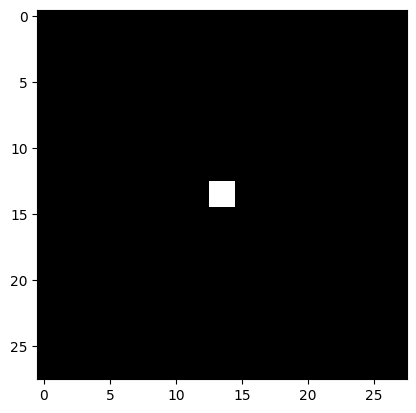

In [693]:
#@title Lets generate an image! (basic testing that the generator works, with animation)

generator = build_generator()

def animate_ca(generator, h=1, w=1):
    x = make_seed(1, height=h, width=w)

    for i in range(1):
        x = generator(x, training=False)
        plt.imshow(to_greyscale(x)[0, :, :, 0], cmap='gray')
        plt.show()
        # print(x[0,:,:,0].numpy().max())

    return x

x = animate_ca(generator)

In [694]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

In [695]:
#@title Discriminator model and utils


def build_discriminator(input_shape=(28, 28, 1)):

    const = ClipConstraint(0.01)
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const,
                                     input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))

    return model

    # # old, simple model
    # model = Sequential()

    # model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    # model.add(LeakyReLU())
    # model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    # model.add(LeakyReLU())
    # model.add(Flatten())
    # model.add(Dense(1))  # No activation because the binary crossentropy loss function does the activation as well (using from logits)

    # return model

discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.summary()


Model: "sequential_231"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_447 (Conv2D)         (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_188 (LeakyReLU  (None, 14, 14, 64)        0         
 )                                                               
                                                                 
 dropout_188 (Dropout)       (None, 14, 14, 64)        0         
                                                                 
 conv2d_448 (Conv2D)         (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_189 (LeakyReLU  (None, 7, 7, 128)         0         
 )                                                               
                                                                 
 dropout_189 (Dropout)       (None, 7, 7, 128)      

In [696]:
#@title Now let's try discriminate! (basic testing that the disc model works)

discriminator = build_discriminator()
decision = discriminator(x[:, :, :, :1])
print(decision)

tf.Tensor([[0.00346692]], shape=(1, 1), dtype=float32)


In [697]:

#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72)
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).

    x = test_input

    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    for i in tf.range(iter_n):
        x = model(x)

    predictions = x

    print("Iters: ", iter_n)
    plt.imshow(to_greyscale(predictions)[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    print(x.shape)

    return to_greyscale(predictions)[0, :, :, 0]


In [698]:
# @title Now let's generate an image, discriminate, and calculate all the losses!

EPOCHS = 100
num_examples_to_generate = BATCH_SIZE

h = 28
w = 28
seed = make_seed(1, height = 1, width = 1)

generator = build_generator()
discriminator = build_discriminator()

# generator.set_weights(ca.get_weights())

# Learning rate and schedule
lr_gen = 2e-3
lr_disc = 2e-3

lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_gen, lr_gen * 0.1])
lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_disc, lr_disc * 0.1])

# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

g_loss_log = []
d_loss_log = []

# loss0 = generator_loss(seed).numpy()
!mkdir -p train_log && rm -f train_log/*

x = make_seed(1)

UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

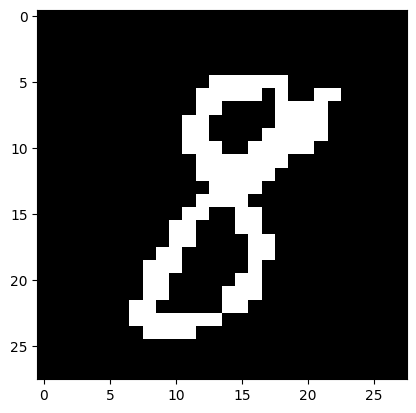

In [ ]:
rounded_target_image = tf.where(target_image > 0.5, 1.0, 0.0)

plt.imshow(rounded_target_image[:, :, :] * 127.5 + 127.5, cmap='gray')

Pretrain the generator

In [ ]:
#@title Reimplement the original training architechture to learn a single exact digit!

#@title Initialize Training { vertical-output: true}

h = 28
w = 28
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 0:1] = 1.0

def loss_f(x):
  return tf.reduce_mean(tf.square(to_greyscale(x)-rounded_target_image), [-2, -3, -1])

ca = build_generator()

loss_log = []

lr = 2e-4
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)

loss0 = loss_f(seed).numpy()

!mkdir -p train_log && rm -f train_log/*

23467.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
zsh:1: no matches found: train_log/*


Iters:  tf.Tensor(70, shape=(), dtype=int32)


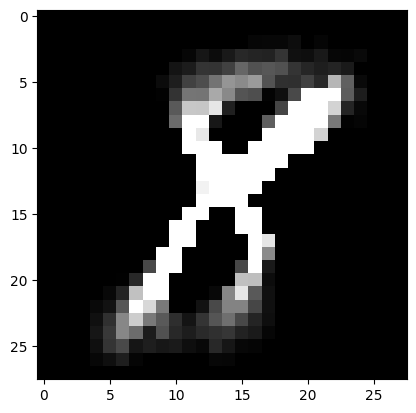

(1, 28, 28, 16)
Epoch 1501, Loss: 0.0260


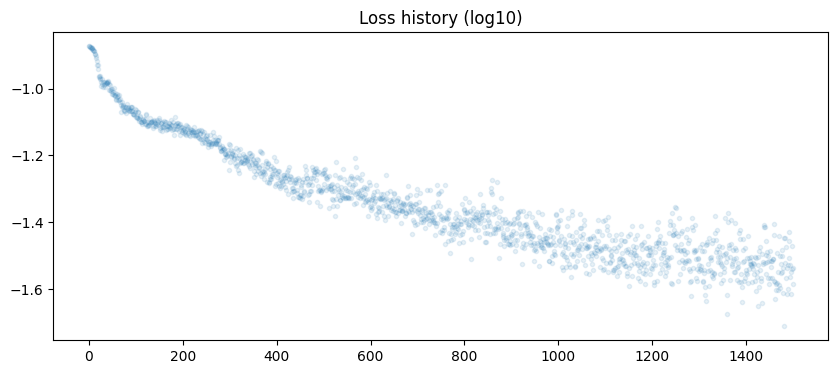

 step: 1501, log10(loss): -1.585

In [ ]:
#@title Original Training Loop {vertical-output: false}

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
    reg_losses = tf.add_n(ca.dmodel.losses)
    total_loss = loss + reg_losses
  grads = g.gradient(total_loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, total_loss

if TRAIN_GENERATOR: 
  for i in range(1500+1):

      x0 = np.repeat(seed[None, ...], 1, 0)

      x, loss = train_step(x0)

      step_i = len(loss_log)
      loss_log.append(loss.numpy())

      if step_i%100 == 0:
          clear_output(wait=True)
          if tf.reduce_all(generate_and_save_images(ca,
                                  i + 1,
                                  x0) == 0.0): 
              ca.reinitialize_weights() # restart training if the model collapses
          # Print the losses
          print(f"Epoch {i + 1}, Loss: {loss:.4f}")
          plot_loss(loss_log)

      print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [ ]:
# Get the weights of the first layer
weights = ca.dmodel.layers[0].weights[0].numpy()

# Normalize the weights to range 0-1 for visualization
weights_min = weights.min()
weights_max = weights.max()

print(weights_min, weights_max)

-0.096510395 0.11527067


In [ ]:
if TRAIN_GENERATOR: 
  ca.save_weights(f"ca_{TARGET_DIGIT}.h5")

In [ ]:
ca.load_weights(f"ca_{TARGET_DIGIT}.h5")

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def print_image_sample(images): 
    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

def noisify(images, noise_factor):

    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    # Clip the values to be between 0 and 1
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images


In [ ]:
def add_noise_to_weights(model, noise_level=0.01):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if the layer has weights
            noisy_weights = [w + noise_level * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(noisy_weights)

In [ ]:
#@title New Training Loop {vertical-output: false}

noise_factor = 0

@tf.function
def train_step(images, labels, update_gen=True, update_disc=False, gen_batch_size = 1):
    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    x = make_seed(gen_batch_size, height=1, width=1)  

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        for i in tf.range(iter_n):
            x = generator(x, training=True)  # Process the entire batch
        real_output = discriminator(noisify(images, noise_factor), training=True)
        fake_output = discriminator(noisify(to_greyscale(x)[:, :, :, 0], noise_factor), training=True)
        disc_loss = discriminator_loss(real_output, labels,  fake_output)
        gen_loss = generator_loss(fake_output)
    # tf.print("Fake output:", disc_loss)
    # tf.print("Real output:", gen_loss)


    # Compute gradients and update
    # TODO plot gradient norms
    if update_gen:
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_generator = [g/(tf.norm(g)+1e-8) for g in gradients_of_generator]
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # if disc_loss > gen_loss / 4 or disc_loss > gen_loss:
    if update_disc:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to plot the current losses
def plot_losses(generator_losses, discriminator_losses, epoch):
    fig, axs = plt.subplots(2, figsize=(10, 10))

    axs[0].plot(generator_losses, label='Generator')
    axs[0].set_title(f'Generator Loss During Training - Epoch {epoch}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(discriminator_losses, label='Discriminator')
    axs[1].set_title(f'Discriminator Loss During Training - Epoch {epoch}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Training Loop
def train(dataset, epochs, gen_iters_per_disc_iter=1, add_noise_every=1, gen_batch_size=1):

    # Initialise lists for storing losses
    generator_losses = []
    discriminator_losses = []
    update_disc = tf.constant(False)
    clear_output(wait=True)
    generate_and_save_images(generator,
                            0,
                            seed)

    print("Getting warmed up...")

    for epoch in range(epochs):
        start = time.time()

        # Initialise the loss accumulators for the epoch
        epoch_gen_loss = 0.0
        epoch_disc_loss = 0.0
        batch_count = 0

        # Determine the number of batches to sample (1/10th of the dataset)
        total_batches = len(dataset)
        sampled_batches = total_batches // 5

        # Sample a subset of batches to iterate over
        sampled_dataset = dataset.shuffle(BUFFER_SIZE).take(sampled_batches)
        
        for image_batch, label_batch in sampled_dataset:
            # print_image_sample(image_batch[:16])
            # print(label_batch)

            if (epoch) % add_noise_every == 0: 
                add_noise_to_weights(generator, noise_level=0)
            
            if (epoch) % gen_iters_per_disc_iter == 0: 
                update_disc = tf.constant(True)
            else: 
                update_disc = tf.constant(False)
            gen_loss, disc_loss = train_step(image_batch, label_batch, update_disc=update_disc, gen_batch_size=gen_batch_size)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            batch_count += 1


        # Average the losses over all batches in the epoch
        epoch_gen_loss /= batch_count
        epoch_disc_loss /= batch_count

        epoch_gen_loss = epoch_gen_loss
        epoch_disc_loss = epoch_disc_loss

        # Append the average losses to their respective lists
        generator_losses.append(epoch_gen_loss)
        discriminator_losses.append(epoch_disc_loss)

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)
        print(batch_count)
        # Print the losses
        print(f"Epoch {epoch + 1}, Generator loss: {epoch_gen_loss:.4f}, Discriminator loss: {epoch_disc_loss:.4f}")
        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")
        plot_losses(generator_losses, discriminator_losses, epoch + 1)


        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)
    plot_losses(generator_losses, discriminator_losses, epoch + 1)

    # x, g_loss, d_loss = train_step(real_data)
    # Logging, visualisation, etc.

    # step_i = len(loss_log)
    # g_loss_log.append(g_loss.numpy())
    # d_loss_log.append(d_loss.numpy())

    # if step_i%10 == 0:
    #     generate_pool_figures(pool, step_i)
    # if step_i%100 == 0:
    #     clear_output()
    #     visualize_batch(x, x, step_i)
    #     plot_loss(g_loss_log)
    #     plot_loss(d_loss_log)
    #     export_model(ca, 'train_log/%04d'%step_i)

In [ ]:
#@title Wasserstein loss
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    y_true = tf.where(y_true == 1., tf.constant(-1., dtype=tf.float32), tf.constant(1., dtype=tf.float32))
    return tf.keras.backend.mean(y_true * y_pred)

# def build_critic(input_shape=(28, 28, 1)):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# weight constraint
# 	const = ClipConstraint(0.01)
# 	# define model
# 	model = tf.keras.Sequential()
# 	# downsample to 14x14
# 	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=input_shape))
# 	model.add(BatchNormalization()) #kernel_constraint=const
# 	model.add(LeakyReLU(alpha=0.2))
# 	# downsample to 7x7
# 	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
# 	model.add(BatchNormalization()) #kernel_constraint=const
# 	model.add(LeakyReLU(alpha=0.2))
# 	# scoring, linear activation
# 	model.add(Flatten())
# 	model.add(Dense(1)) #kernel_constraint=const
# 	# compile model
# 	opt = RMSprop(lr=0.00005)
# 	model.compile(loss=wasserstein_loss, optimizer=opt)
# 	return model

# critic = build_critic()
# critic.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# critic.summary()
    



In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # return -tf.reduce_mean(fake_output) # WGAN
    return cross_entropy(tf.ones_like(fake_output), fake_output) # Normal cross entropy

def discriminator_loss(real_output, real_labels, fake_output):

    # return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # real_targets = tf.where(real_labels == TARGET_DIGIT, tf.ones_like(real_labels), tf.zeros_like(real_labels))
    # real_loss = cross_entropy(real_targets, real_output)
    # return real_loss

    if WGAN:
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = wasserstein_loss(real_targets, real_output)
        # return real_loss
        fake_loss = wasserstein_loss(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * 0 + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss
    else: 
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = cross_entropy(real_targets, real_output)
        # return real_loss
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * 0 + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss


if TRAIN_DISCRIMINATOR:
    EPOCHS = 1000
    num_examples_to_generate = BATCH_SIZE


    h = 28
    w = 28
    seed = make_seed(1, height = 1, width = 1)

    generator = build_generator()
    discriminator = build_discriminator()

    generator.set_weights(ca.get_weights())

    g_loss_log = []
    d_loss_log = []

    loss0 = generator_loss(seed).numpy()
    !mkdir -p train_log && rm -f train_log/*

    noise_factor = 0
    lr_gen = 2e-50
    lr_disc = 1e-4

    lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr_gen, lr_gen * 0.1])
    lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr_disc, lr_disc * 0.1])

    # Optimizers
    generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
    discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

    train(x_train, EPOCHS)

In [ ]:
if TRAIN_DISCRIMINATOR:
  discriminator.save_weights(f"disc_{TARGET_DIGIT}.h5")

In [ ]:
discriminator.load_weights(f"disc_{TARGET_DIGIT}.h5")

WGAN critic

In [ ]:
#@title Initialize Training

def generator_loss(fake_output):
    # return -tf.reduce_mean(fake_output) # WGAN
    if WGAN: 
        wgan_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        l2_loss = tf.add_n(ca.dmodel.losses)
        return wgan_loss + l2_loss
    else: 
        cross_entropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output) # Normal cross entropy
        l2_loss = tf.add_n(ca.dmodel.losses)
        return cross_entropy_loss + l2_loss

def discriminator_loss(real_output, real_labels, fake_output):

    if WGAN:
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = wasserstein_loss(real_targets, real_output)
        # return real_loss
        fake_loss = wasserstein_loss(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * BATCH_SIZE + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss
    else: 
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = cross_entropy(real_targets, real_output)
        # return real_loss
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss

In [ ]:
EPOCHS = 1000


h = 28
w = 28
seed = make_seed(1, height = 1, width = 1)

generator = build_generator(l2_reg = 0)
discriminator = build_discriminator()

generator.set_weights(ca.get_weights())
discriminator.load_weights(f"disc_{TARGET_DIGIT}.h5")

g_loss_log = []
d_loss_log = []

loss0 = generator_loss(seed).numpy()
!mkdir -p train_log && rm -f train_log/*



# TODO consider weights and biases, tensorboard

23651.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
zsh:1: no matches found: train_log/*


In [ ]:
noise_factor = 0
lr_gen = 2e-5
lr_disc = 2e-4

lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_gen, lr_gen * 0.1])
lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_disc, lr_disc * 0.1])

# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

"""
pretrain on multiple images 
regularised to keep weights small 
WGAN with regularisation
Plot on different axes
proper evaluation
explore adversarial part 
"""


'\npretrain on multiple images \nregularised to keep weights small \nWGAN with regularisation\nPlot on different axes\nproper evaluation\nexplore adversarial part \n'

Iters:  tf.Tensor(70, shape=(), dtype=int32)


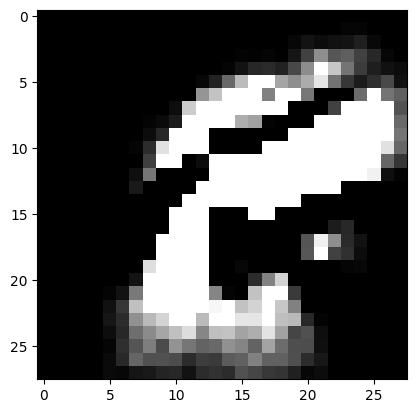

(1, 28, 28, 16)
9
Epoch 39, Generator loss: 0.7864, Discriminator loss: 2.4958
Time for epoch 39 is 1.6391658782958984 sec


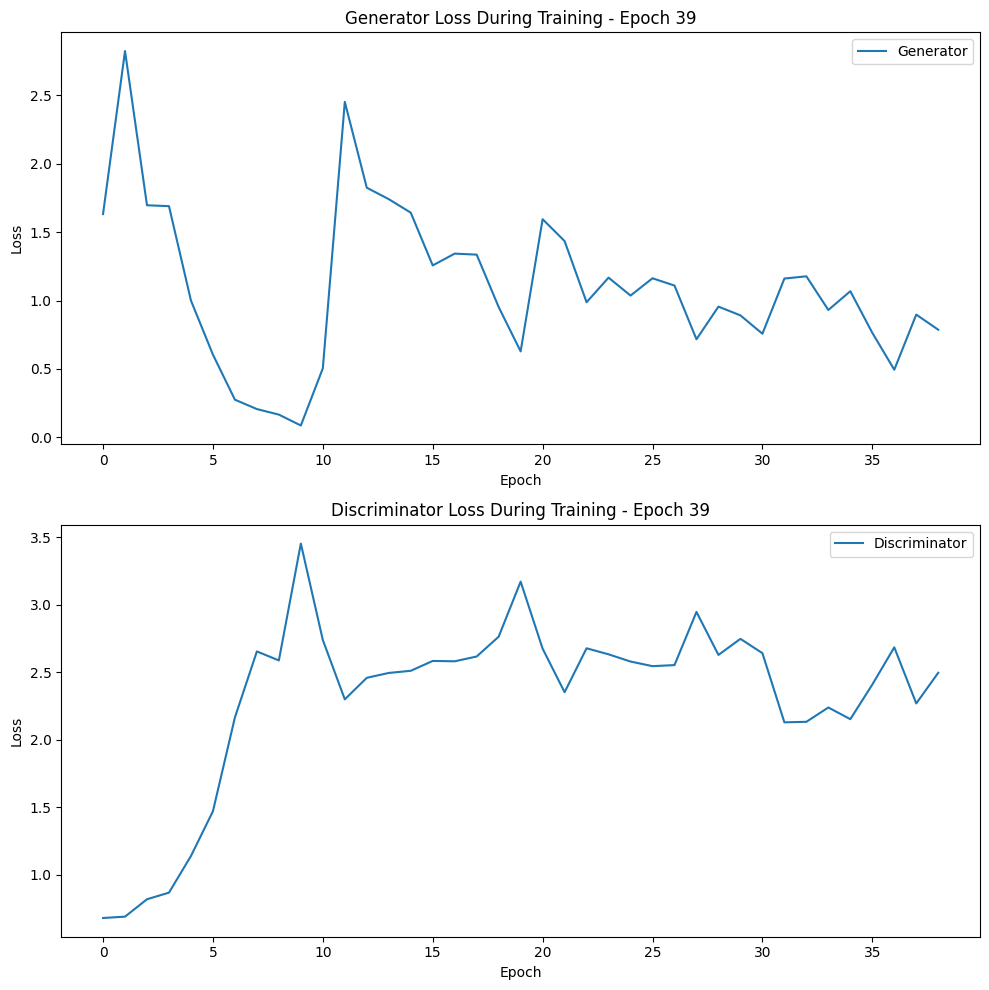

KeyboardInterrupt: 

In [ ]:
train(x_train, EPOCHS, gen_iters_per_disc_iter=100, add_noise_every=1, gen_batch_size=1)

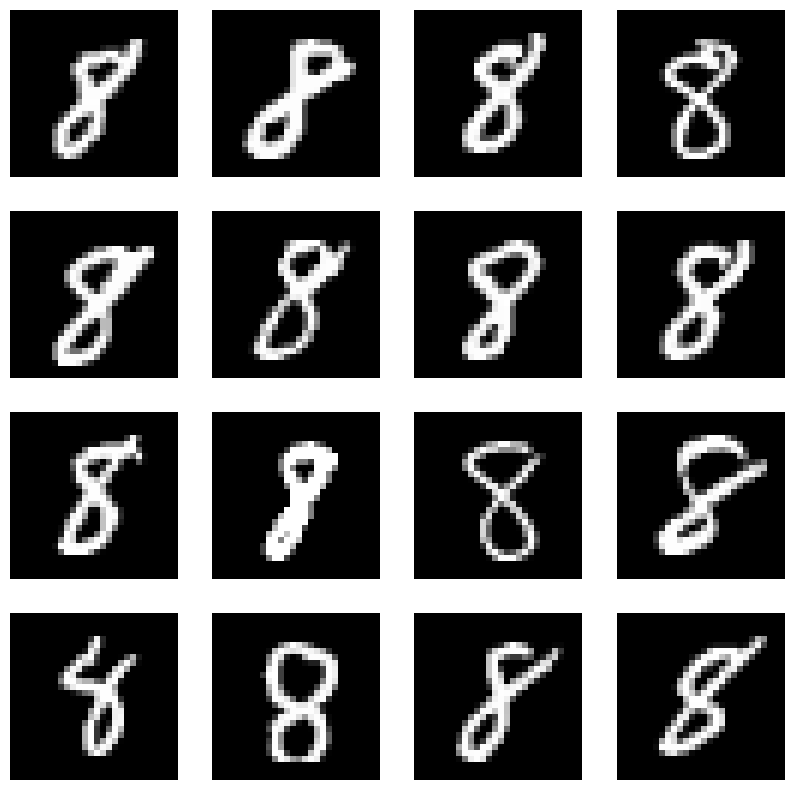

tf.Tensor(
[[0.97153336]
 [0.8682528 ]
 [0.96420485]
 [0.9520798 ]
 [0.9700844 ]
 [0.90510434]
 [0.9608536 ]
 [0.98449695]
 [0.92040277]
 [0.8205673 ]
 [0.8504406 ]
 [0.88278365]
 [0.41281202]
 [0.8887475 ]
 [0.90634936]
 [0.86298555]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_target[:16], 0))
print(tf.sigmoid(discriminator(images_of_target[:16])))

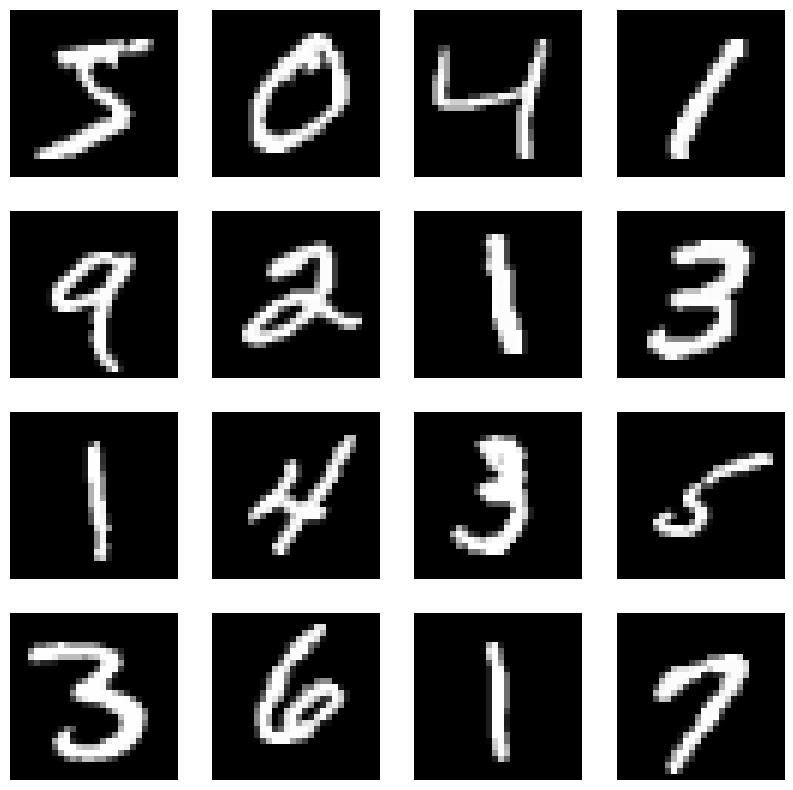

tf.Tensor(
[[0.05339272]
 [0.00971282]
 [0.00958136]
 [0.48083043]
 [0.34559682]
 [0.57327545]
 [0.19094017]
 [0.3342823 ]
 [0.2498089 ]
 [0.05236363]
 [0.21639939]
 [0.22484137]
 [0.09962499]
 [0.05332569]
 [0.40479288]
 [0.01612917]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_others[:16], 0))
print(tf.sigmoid(discriminator(images_of_others[:16])))

Iters:  tf.Tensor(70, shape=(), dtype=int32)


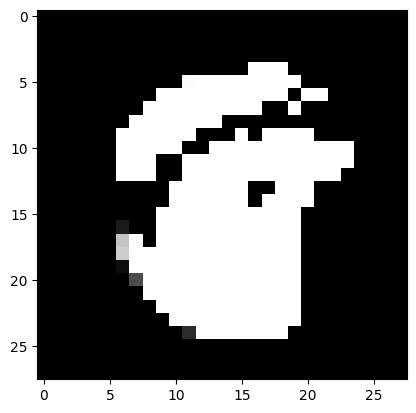

(1, 28, 28, 16)
tf.Tensor([[0.03977384]], shape=(1, 1), dtype=float32)


In [ ]:
image = noisify(generate_and_save_images(generator,0,seed)[None,...], 0)
# print_image_sample(image[..., None])

print(tf.sigmoid(discriminator(image)))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'